<h1><center> ODABIR ZNAČAJKI </center></h1>

 <center>
    <h1><center>Microsoft malware classification</center></h1>
    <i>Klasifikacija zlonamjernog softvera</i> 
    <br><br>
    PRIRODOSLOVNO MATEMATIČKI FAKULTET - MATEMATIČKI ODSJEK <br>
    <b>Lipanj 2020.</b> 
    <br><br>
    <i>Stanišić Matea, Škrabo Petra, Terzanović Mateja, Tolja Margarita</i>  
</center>

***

[comment]: <> (Paketi koje je potrebno instalirati prije pokretanja bilježnica: <br>)
[comment]: <> (<code>conda install -c districtdatalabs yellowbrick</code> <br>)

In [76]:
# libraries to be used 
import numpy as np
import pandas as pd
import seaborn as sn
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

import sklearn as sk
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split as tts

from functions.draw_heatmap import *
from functions.univariate import *
from functions.fs_helper import *

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
    
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

<br>

# Značajke

U sljedećih nekoliko linija učitati ćemo značajke koje smo rudarili na način prikazan u bilježnici [Feature extraction](https://github.com/tomarga/Machine-Burning/blob/master/src/Feature%20extraction.ipynb). <br>
Analiza istih nalazi se u [Projektnom prijedlogu](https://github.com/tomarga/Machine-Burning/blob/master/src/%5Bproject%20proposal%5D%20microsoft%20malware%20classification.ipynb). 


Vidimo da orginalnih značajki ima $1693$. Kako ne bi koristili svih $1693$ značajki pri izradi modela i pri tome <i>overfittali</i> isti, u ovoj bilježnici nastojati ćemo odabrati manji skup značajki koje će dovoljno dobro opisivati željene klase <i>malware</i>-a. 

[comment]: <> (Za početak ćemo odabrati 800 najboljih značajki univarijantnom metodom, a nakon toga ćemo taj skup dodatno smanjiti metodom slučajnih šuma.)

In [2]:
# loading all features in train set
features_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/merged_all_features.csv")
features_train.head()

Id  Class  byte_1G_00  byte_1G_01  byte_1G_02  \
0  01kcPWA9K2BOxQeS5Rju      1       21091        1213         726   
1  04EjIdbPV5e1XroFOpiN      1       40030        1980        1226   
2  05EeG39MTRrI6VY21DPd      1       19419         955         693   
3  05rJTUWYAKNegBk2wE8X      1       79568        6445        3143   
4  0AnoOZDNbPXIr2MRBSCJ      1       25791        1202         569   

   byte_1G_03  byte_1G_04  byte_1G_05  byte_1G_06  byte_1G_07  ...  visualc  \
0         817        1257         625         550         523  ...        0   
1        1193        1971        1096         961         755  ...        0   
2         656         832         463         370         510  ...        0   
3        2517        4982        1824        2125        2964  ...        0   
4         750         948         456         405         517  ...        0   

   ___security_cookie  assume  callvirtualalloc  exportedentry  hardware  \
0                   0       0                 0              0         0   
1                   0       0                 0              0         0   
2                   0       0                 0              0         0   
3                   0       2                 0              0         0   
4                   0       0                 0              0         0   

   hkey_current_user  hkey_local_machine  sp-analysisfailed  unableto  
0                  0                   0                  0         0  
1                  0                   0                  0         0  
2                  0                   0                  0         0  
3                  0                   0                  0         0  
4                  0                   0                  0         0  

[5 rows x 1695 columns]

In [3]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10867 entries, 0 to 10866
Columns: 1695 entries, Id to unableto
dtypes: float64(303), int64(1391), object(1)
memory usage: 140.5+ MB


In [4]:
malware_classes_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/malware_classes_train.csv")

<br>

In [5]:
# loading all features in train set
features_test1 = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/test_features_first_10000.csv")
features_test2 = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/test_features_last_873.csv")
features_test = features_test1.append(features_test2)
features_test.head()

Id  byte_1G_00  byte_1G_01  byte_1G_02  byte_1G_03  \
0  ITSUPtCmh7WdJcsYDwQ5       26006        1711        2279        1467   
1  Ig2DB5tSiEy1cJvV0zdw       14753        1685        1742        1235   
2  Jmo6eIhLZ4t9r8QsxEg5       13279        1945        1783        1421   
3  JtPFl4ewgdD78OzCMa3o        7558         944         804         883   
4  K3ZtByPHGSFYNljDUEXp        8504        4195        3019        3099   

   byte_1G_04  byte_1G_05  byte_1G_06  byte_1G_07  byte_1G_08  ...  visualc  \
0        1691        1168        1048        1126        2595  ...        0   
1        1476        1135        1010        1038        1449  ...        0   
2        1496        1351        1130        1007        1546  ...        0   
3         814        1072         616         723         876  ...        0   
4        3101        3200        3161        3183        3070  ...        0   

   ___security_cookie  assume  callvirtualalloc  exportedentry  hardware  \
0                   0       7                 0              0         0   
1                   0       6                 0              0         0   
2                   0      12                 0              0         0   
3                   0       0                 0              0         0   
4                   0       0                 0              0         0   

   hkey_current_user  hkey_local_machine  sp-analysisfailed  unableto  
0                  0                   0                  0         0  
1                  0                   0                  0         0  
2                  0                   0                  0         0  
3                  0                   0                  0         0  
4                  0                   0                  0         0  

[5 rows x 1694 columns]

In [6]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10873 entries, 0 to 872
Columns: 1694 entries, Id to unableto
dtypes: float64(303), int64(1390), object(1)
memory usage: 140.6+ MB


<br> 
Prije nego što krenemo smanjivati dimenzionalnost prostora značajki, pogledajmo postoje li podaci s <code>NaN</code> vrijednostima.

In [ ]:
# find features with NaN values on trainset
features_with_null_values = []
for i in range(features_train.shape[1]) :
    if features_train.count()[i] < features_train.shape[0] :
        #print( i, features.count().index[i], features.count()[i] ) 
        features_with_null_values.append( features_train.count().index[i] )
        
print( features_with_null_values )

In [ ]:
# find features with NaN values on testset
features_with_null_values_test = []
for i in range(features_test.shape[1]) :
    if features_test.count()[i] < features_test.shape[0] :
        #print( i, features.count().index[i], features.count()[i] ) 
        features_with_null_values_test.append( features_test.count().index[i] )
        
print( features_with_null_values_test )

Vidimo da se i u slučaju _train_ i _test_ skupa podataka radi o značajkama iz skupine **sekcije** (SEC) i **data define** (DD). Po analizi iz [Feature extraction](https://github.com/tomarga/Machine-Burning/blob/master/src/Feature%20extraction.ipynb) bilježnice, znamo da se sve ove značajke odnose na omjer broja određenih linija (SEC) ili omjer korištenja određenih instrukcija (DD) u <b>.asm</b> datoteci. <code>NaN</code>  vrijednosti su stoga rezultat dijeljenja $\frac{0}{0}$. Informacija da ne postoji određenih linija ili instrukcija u nekoj sekciji <b>.asm</b> datoteke nam nije beznačajna, tako da na mjesta <code>NaN</code> vrijednosti postavljamo $0$.

To smo prethodno učinili i spremili u datoteku koju ovdje učitavamo.
<br>

In [7]:
md5hash_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/md5hash_train.csv")
features_train_with_filled_NaN_without_id = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/features_train_with_filled_NaN_without_id.csv")

md5hash_test = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/md5hash_test.csv")
features_test_with_filled_NaN_without_id = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/features_test_with_filled_NaN_without_id.csv")

<br><br>

## Univarijantni odabir značajki

Ova metoda služi nam kao prvi korak u procesu odabira značajki.
<br>
<span style="color:orange">Mage/Pere budete vi ovdje nesto pametno napisale?</span>

- izbačeno  208  konstantnih značajki


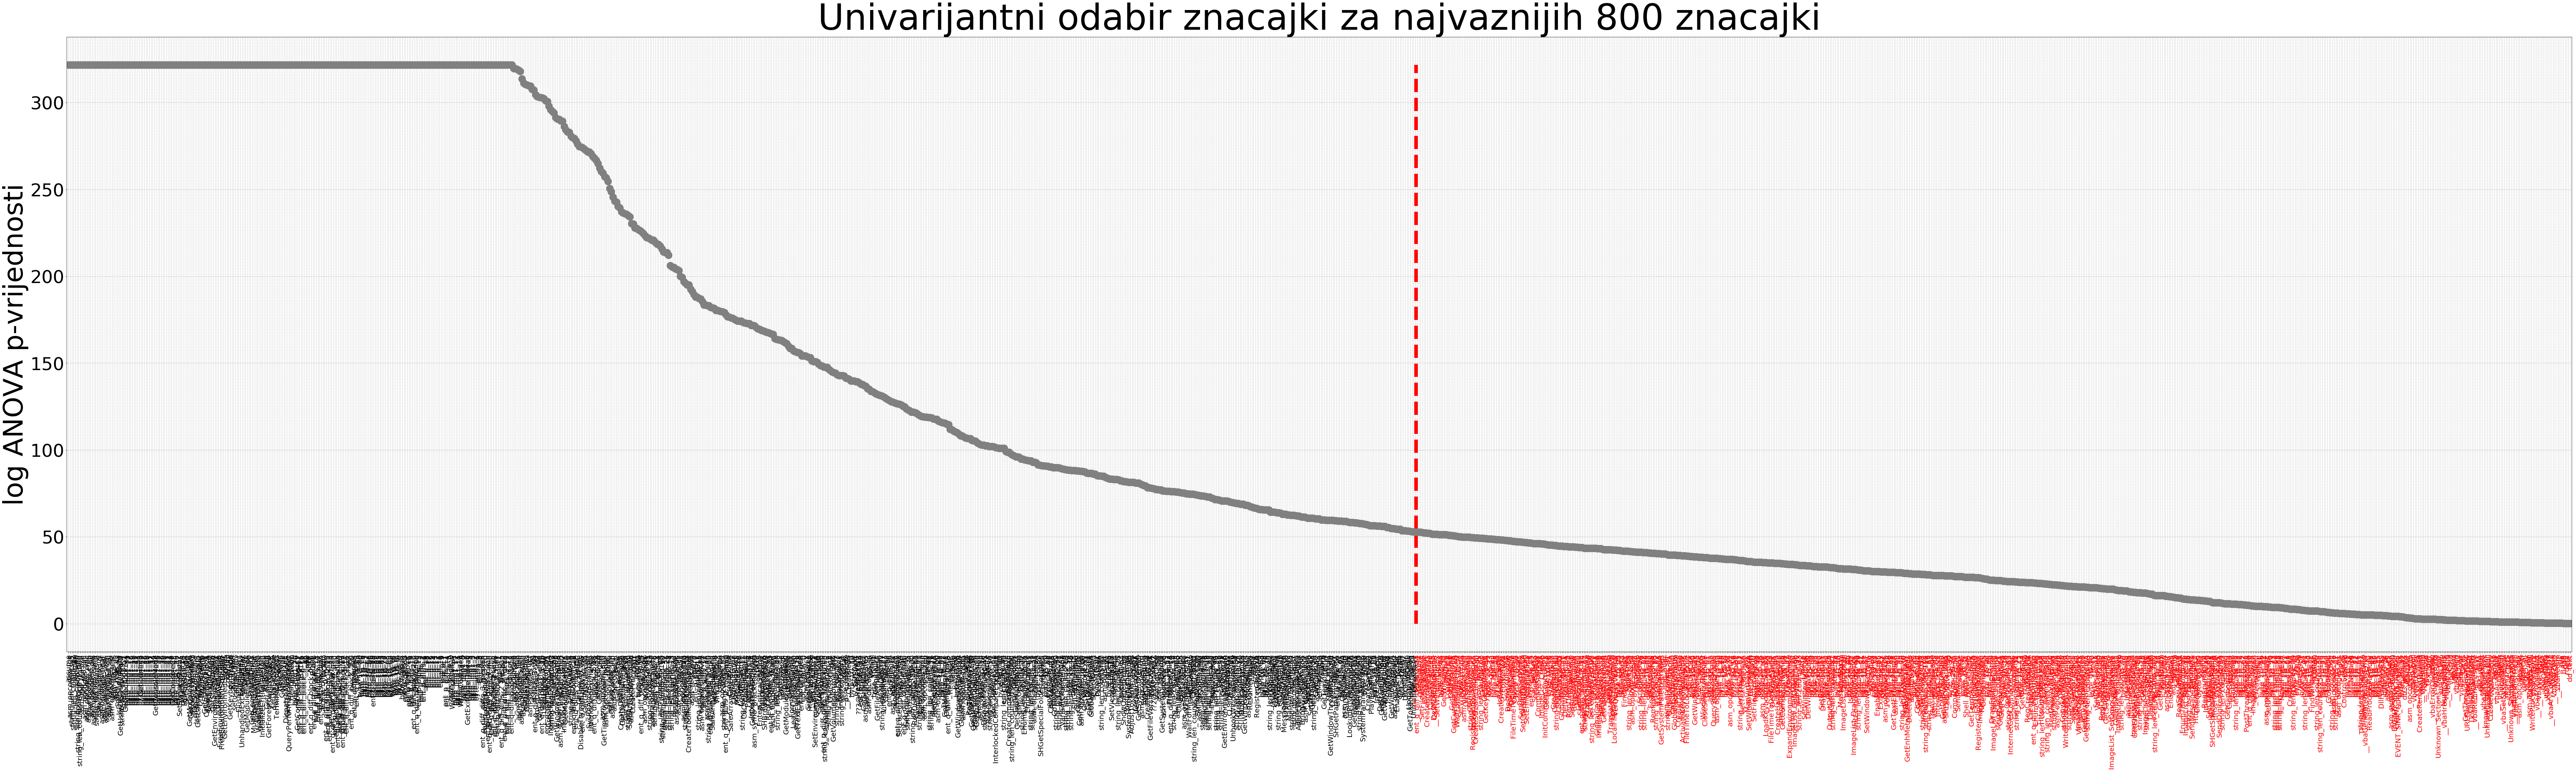

In [8]:
# univariate method on all features
with warnings.catch_warnings():
    features_univariate = univariate_plot( malware_classes_train.values.ravel().copy(), features_train_with_filled_NaN_without_id.copy(), 800 )

Funkcijom <code>univariate_plot</code>, osim što smo grafički prikazali odabir pola ($800$) najboljih značajki, vratili smo i varijablu koja se sastoji od imena odabranih značajki te njihovih važnosti dobivenih univarijantnom metodom. Prvih pet najznačajnijih značajki možemo vidjeti u sljedećoj tablici.

In [9]:
# selected features by univariate method
features_univariate.head()

# save
# features_univariate.to_csv('selected_univariate_features_train_800_names_and_scores.csv', index= False)

feature_names  feature_score
0                assume     321.607245
1       asm_opcodes_jge     321.607245
2   string_len_counts_5     321.607245
3  string_len_counts_52     321.607245
4               _acmdln     321.607245

Izabrane značajke ćemo zapamtiti i na njima dalje raditi detaljniju selekciju.

In [10]:
# filter original features train on selected features by univariate method
selected_univariate_features_train = features_train_with_filled_NaN_without_id[features_univariate["feature_names"].tolist()].copy()

# filter original features test on selected features by univariate method
selected_univariate_features_test = features_test_with_filled_NaN_without_id[features_univariate["feature_names"].tolist()].copy()


# save train
#selected_univariate_features_train.to_csv('selected_univariate_features_train_800.csv', index= False)
# save test
#selected_univariate_features_test.to_csv('selected_univariate_features_test_800.csv', index= False)


In [ ]:
# load train
# selected_univariate_features_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/selected%20features/univariate/selected_univariate_features_train_800.csv")

# load test
# selected_univariate_features_test = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/selected%20features/univariate/selected_univariate_features_test_800.csv")

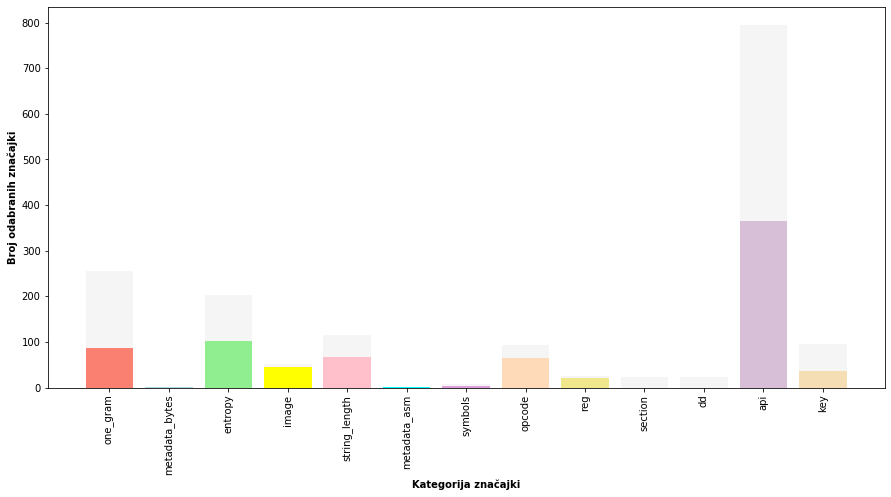

In [26]:
# plot selected features distributed over groups of features
features_type_quantity(features_univariate["feature_names"].tolist(), features_train)

Na gornjem grafu možemo vidjeti da smo univarijantnom metodom odabira značajki izbacili sve značajke iz grupe <code>section</code> i <code>dd</code> što nije dobro. Iz tog razloga odlučili smo se za izbacivanje svih značajki koje koreliraju s nekom drugom kao početnu metodu izbacivanja značajki.

<br><br>

## Izbacivanje koreliranih značajki

Pogledajmo grafički kako značajke međusobno koreliraju.

C:\Users\Matea\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Matea\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


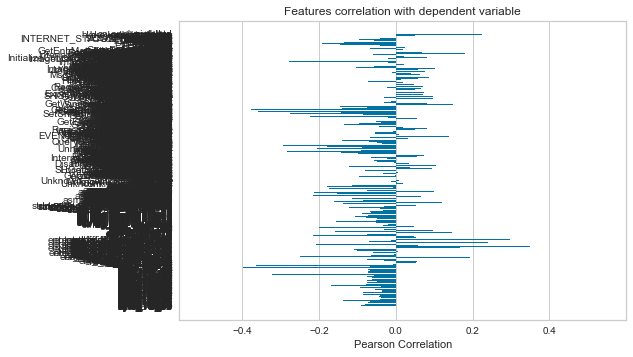

<Figure size 576x396 with 0 Axes>

In [27]:
from yellowbrick.target.feature_correlation import feature_correlation

features = features_train_with_filled_NaN_without_id.columns.values

visualizer = feature_correlation(features_train_with_filled_NaN_without_id, malware_classes_train.values.ravel(), labels=features)
plt.tight_layout()

In [34]:
# remove corelated features
correlated_features = set()
correlation_matrix = features_train_with_filled_NaN_without_id.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
print('Broj koreliranih značajki: ' + str(len(correlated_features)))

Broj koreliranih značajki: 498


In [35]:
correlated_features

# save names of corelated features
#with open('corelated_features.txt', 'w') as f:
#    print(correlated_features, file=f)

{'.bss_por',
 '.edata_por',
 '.rdata:',
 '.rsrc_por',
 '.text:',
 '.tls_por',
 '??3@YAXPAX@Z',
 'CheckMenuItem',
 'CoInitialize',
 'CreateCompatibleDC',
 'CreateWindowExW',
 'DLL',
 'DeleteDC',
 'DeleteMenu',
 'EVENT_SINK_AddRef',
 'EVENT_SINK_QueryInterface',
 'EndPaint',
 'FileTimeToSystemTime',
 'FreeEnvironmentStringsW',
 'GetCPInfo',
 'GetClipBox',
 'GetClipboardData',
 'GetDeviceCaps',
 'GetDlgItem',
 'GetEnvironmentStrings',
 'GetEnvironmentStringsW',
 'GetFileType',
 'GetFileVersionInfoSizeA',
 'GetIconInfo',
 'GetProcAddress',
 'GetPropA',
 'GetScrollPos',
 'GetStringTypeA',
 'GetSysColor',
 'GetWindow',
 'GetWindowLongA',
 'GetWindowLongW',
 'GetWindowRect',
 'GetWindowTextW',
 'HMENU',
 'HWND',
 'HeapFree',
 'HeapReAlloc',
 'HttpOpenRequestA',
 'HttpQueryInfoA',
 'HttpSendRequestA',
 'ImageList_Destroy',
 'ImageList_Draw',
 'ImageList_Write',
 'InitializeCriticalSection',
 'InterlockedDecrement',
 'InternetOpenA',
 'InternetOpenUrlA',
 'IntersectClipRect',
 'InvalidateRect',

In [38]:
# remove corelated features from train and test data
features_train_with_filled_NaN_without_id_no_cor = features_train_with_filled_NaN_without_id.drop(correlated_features, axis=1)
features_test_with_filled_NaN_without_id_no_cor = features_test_with_filled_NaN_without_id.drop(correlated_features, axis=1)

features_train_with_filled_NaN_without_id_no_cor.head()

byte_1G_00  byte_1G_01  byte_1G_02  byte_1G_03  byte_1G_04  byte_1G_05  \
0       21091        1213         726         817        1257         625   
1       40030        1980        1226        1193        1971        1096   
2       19419         955         693         656         832         463   
3       79568        6445        3143        2517        4982        1824   
4       25791        1202         569         750         948         456   

   byte_1G_06  byte_1G_07  byte_1G_08  byte_1G_09  ...  visualc  \
0         550         523        1078         473  ...        0   
1         961         755        2406         550  ...        0   
2         370         510         836         449  ...        0   
3        2125        2964        8301        1530  ...        0   
4         405         517         754         494  ...        0   

   ___security_cookie  assume  callvirtualalloc  exportedentry  hardware  \
0                   0       0                 0              0         0   
1                   0       0                 0              0         0   
2                   0       0                 0              0         0   
3                   0       2                 0              0         0   
4                   0       0                 0              0         0   

   hkey_current_user  hkey_local_machine  sp-analysisfailed  unableto  
0                  0                   0                  0         0  
1                  0                   0                  0         0  
2                  0                   0                  0         0  
3                  0                   0                  0         0  
4                  0                   0                  0         0  

[5 rows x 1195 columns]

In [39]:
# save train
#features_train_with_filled_NaN_without_id_no_cor.to_csv('features_train_with_filled_NaN_without_id_no_cor.csv', index= False)
# save test
#features_test_with_filled_NaN_without_id_no_cor.to_csv('features_test_with_filled_NaN_without_id_no_cor.csv', index= False)

# load train
# features_train_with_filled_NaN_without_id_no_cor = pd.read_csv("")

# load test
# features_test_with_filled_NaN_without_id_no_cor = pd.read_csv("")

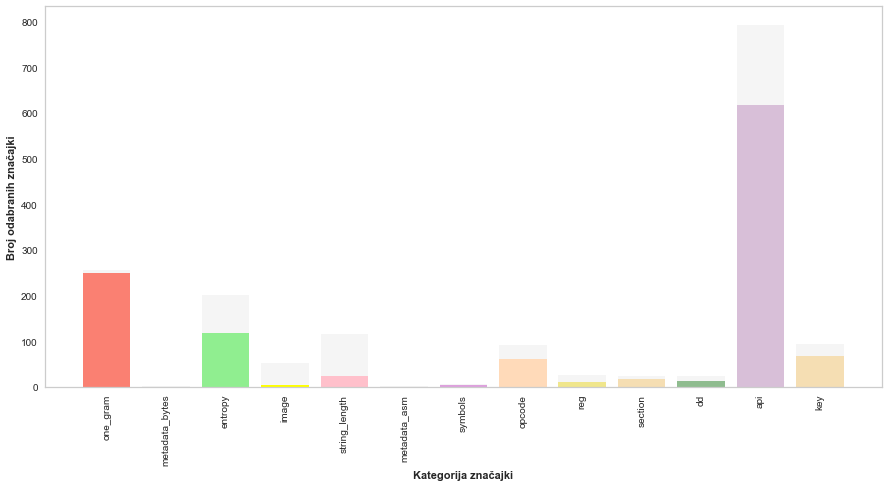

In [45]:
# print distribution of features into groups of features
features_type_quantity(features_train_with_filled_NaN_without_id_no_cor.columns.values, features_train)

<br><br>

## Odabir značajki uz pomoć prediktivnog modela

In [49]:
data = features_train_with_filled_NaN_without_id_no_cor
labels = malware_classes_train.values.ravel()

In [20]:
rfecv_rf3 = RFECV(RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1), 
                 step=1, 
                 cv=StratifiedKFold(n_splits=3),
                 scoring='accuracy')

rfecv_rf3.fit(data, labels)

print("Optimalan broj značajki dobivenih metodom slučajnih šuma : %d" % rfecv_rf3.n_features_)

# plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Broj odabranih značajki")
plt.ylabel("Cross validation točnost (broj točnih klasificiranja)")
plt.plot(range(1, len(rfecv_rf3.grid_scores_) + 1), rfecv_rf3.grid_scores_)
plt.show()

# save
filename = 'rfecv_rf_cv3_no_cor_features.sav'
pickle.dump(rfecv_rf3, open(filename, 'wb'))

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=4,
                                       oob_score=False, random_state=0,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [62]:
# save selected features and their scores
[names_and_importance_scores_sorted_cv3, selected_features_rfc_train_cv3, selected_features_rfc_test_cv3] = rfecv_save(rfecv_rf3, 'cv3_no_cor', features_train_with_filled_NaN_without_id_no_cor.copy() , features_train, features_test_with_filled_NaN_without_id_no_cor.copy())

{'one_gram': 58, 'metadata_bytes': 2, 'entropy': 72, 'image': 30, 'string_length': 13, 'metadata_asm': 2, 'symbols': 1, 'opcode': 28, 'reg': 10, 'section': 0, 'dd': 0, 'api': 32, 'key': 30}


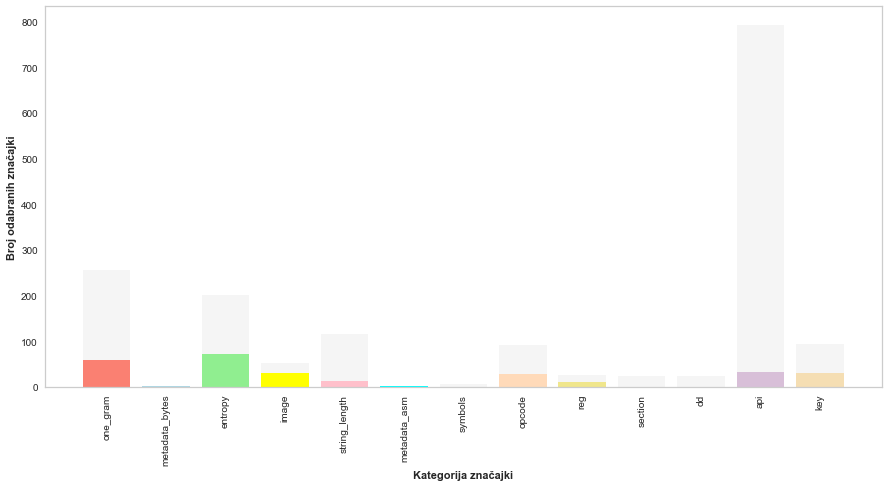

In [67]:
# plot distribution over feature groups
features_type_quantity(names_and_importance_scores_sorted_cv3["feature_name"].tolist(), features_train)

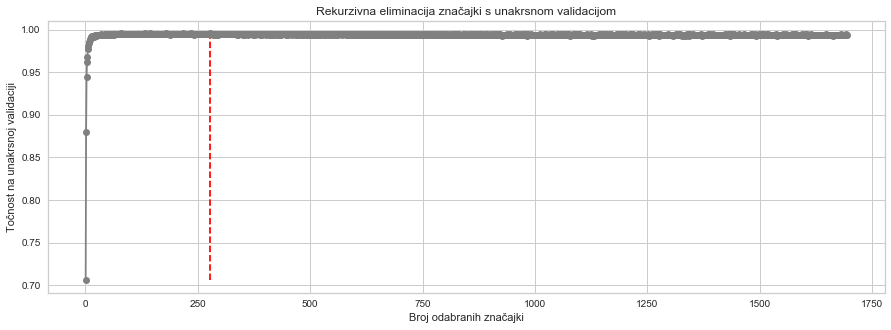

In [64]:
# recursive elimination of features 
rfecv_plot(rfecv_rf3)

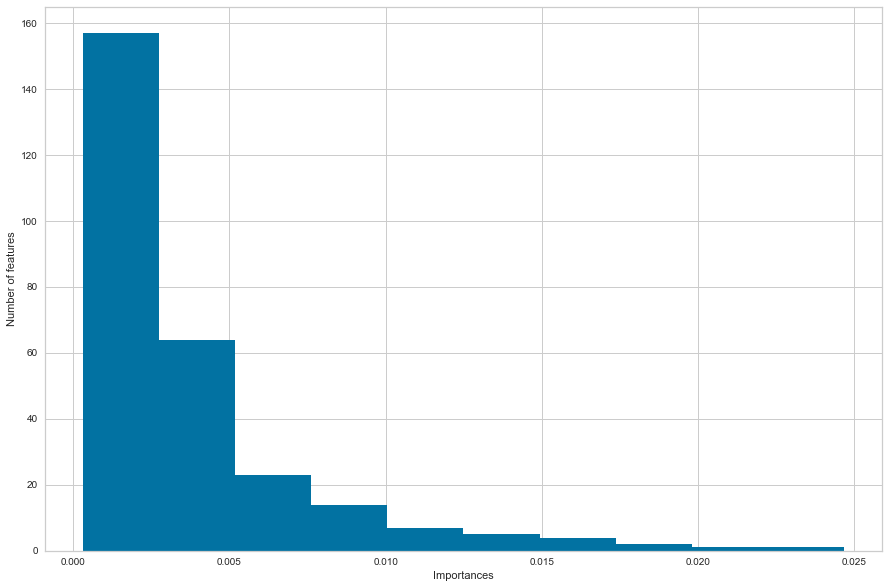

In [65]:
# plot histogram representing distribution of features by feature importance
rfecv_hist(rfecv_rf3)

<br>

Pogledajmo sada kako odabrane značajke koreliraju jedne s drugima.

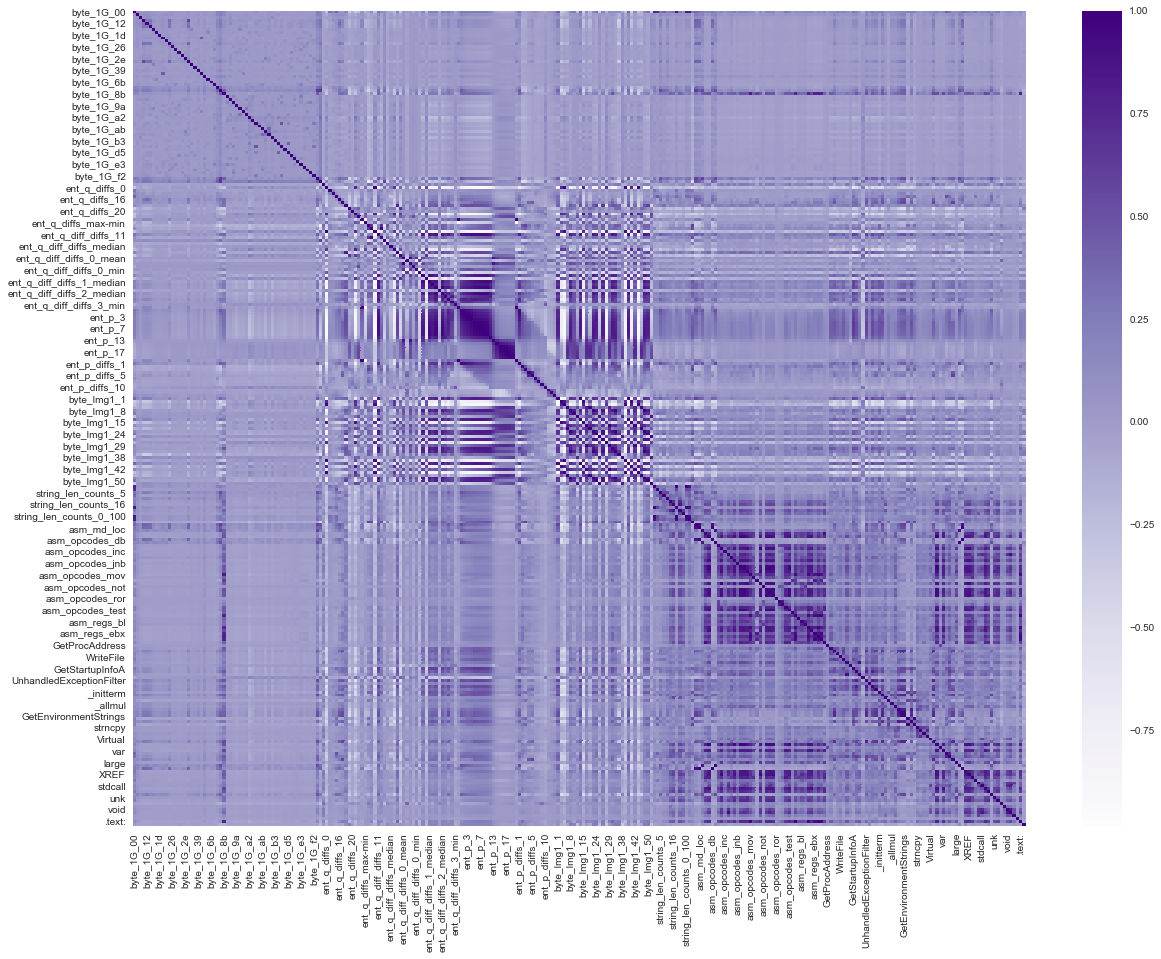

In [68]:
draw_heatmap_anNot(selected_features_rfc_train_cv3, selected_features_rfc_train_cv3.columns)

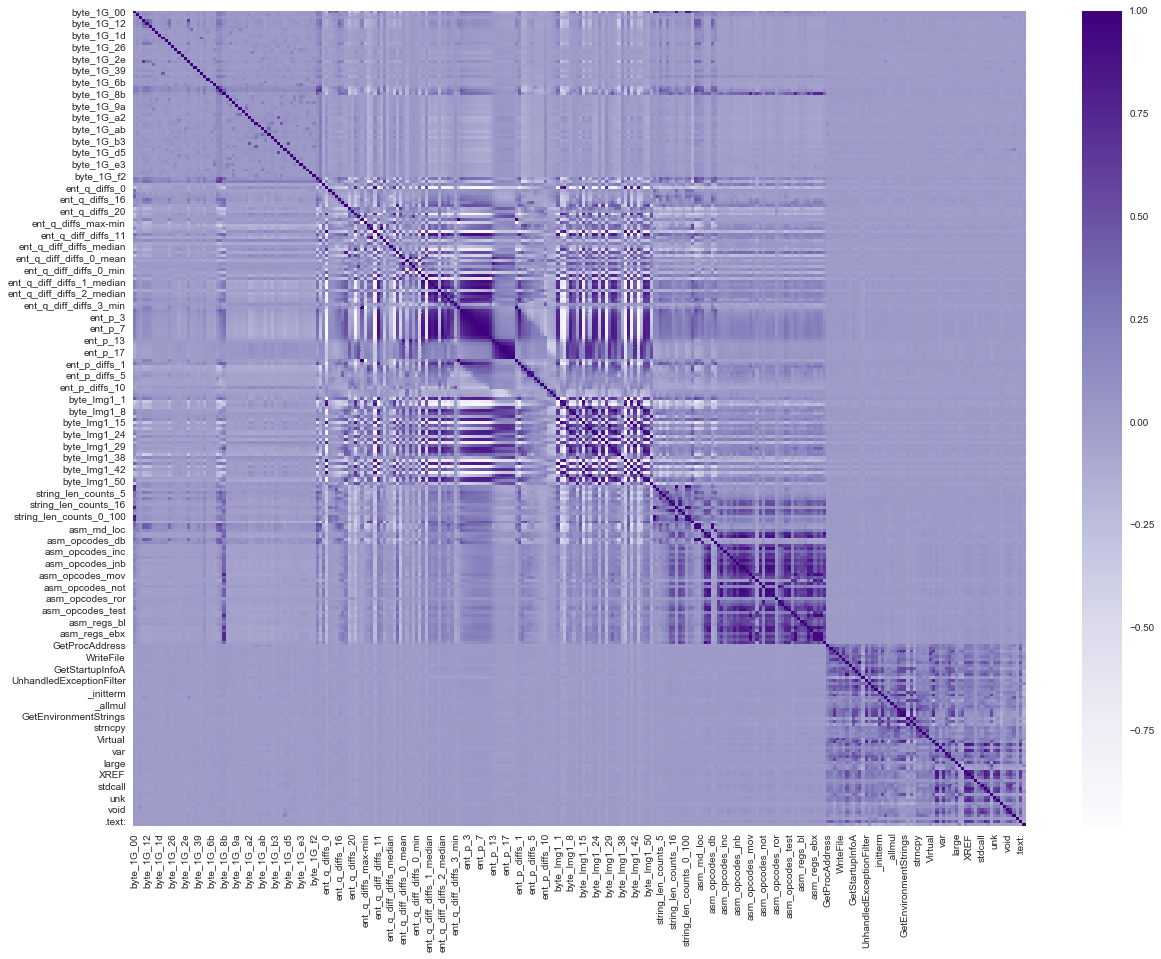

In [69]:
draw_heatmap_anNot(selected_features_rfc_test_cv3, selected_features_rfc_test_cv3.columns)

Vidimo da značajke _train_ i _test_ skupa slično koreliraju, iz čega pretpostavljamo da podaci iz _test_ skupa ne odstupaju previše od nama poznatim podacima iz _train_ skupa.
<span style="color:orange"><i>(uhić nadam se da će tako biti)</i></span>

<br>

In [21]:
rfecv_rf5 = RFECV(RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1), 
                 step=1, 
                 cv=StratifiedKFold(n_splits=5),
                 scoring='accuracy')

rfecv_rf5.fit(data, labels)

print("Optimalan broj značajki dobivenih metodom slučajnih šuma : %d" % rfecv_rf5.n_features_)

# plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Broj odabranih značajki")
plt.ylabel("Cross validation točnost (broj točnih klasificiranja)")
plt.plot(range(1, len(rfecv_rf5.grid_scores_) + 1), rfecv_rf5.grid_scores_)
plt.show()

# save
filename = 'rfecv_rf_cv5_no_cor_features.sav'
pickle.dump(rfecv_rf5, open(filename, 'wb'))

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=-1,
                                       oob_score=False, random_state=0,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [70]:
# save selected features and their scores
[names_and_importance_scores_sorted_cv5, selected_features_rfc_train_cv5, selected_features_rfc_test_cv5] = rfecv_save(rfecv_rf5, 'cv5_no_cor', features_train_with_filled_NaN_without_id_no_cor.copy() , features_train, features_test_with_filled_NaN_without_id_no_cor.copy())

{'one_gram': 68, 'metadata_bytes': 2, 'entropy': 80, 'image': 34, 'string_length': 13, 'metadata_asm': 2, 'symbols': 6, 'opcode': 36, 'reg': 11, 'section': 0, 'dd': 0, 'api': 35, 'key': 32}


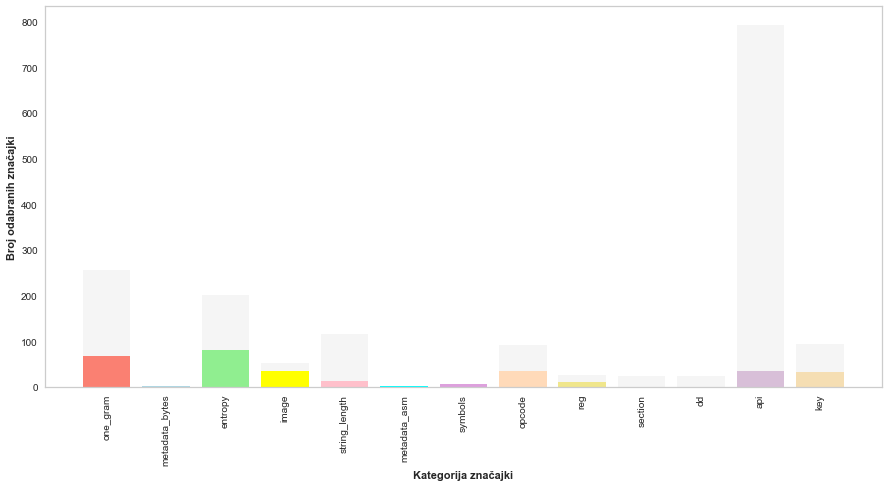

In [71]:
# plot distribution over feature groups
features_type_quantity(names_and_importance_scores_sorted_cv5["feature_name"].tolist(), features_train)

<br><br>

## Smanjivanje dimenzionalnosti

Dimenzije originalnih podataka: (10867, 319)
Dimenzije projiciranih podataka: (10867, 319)


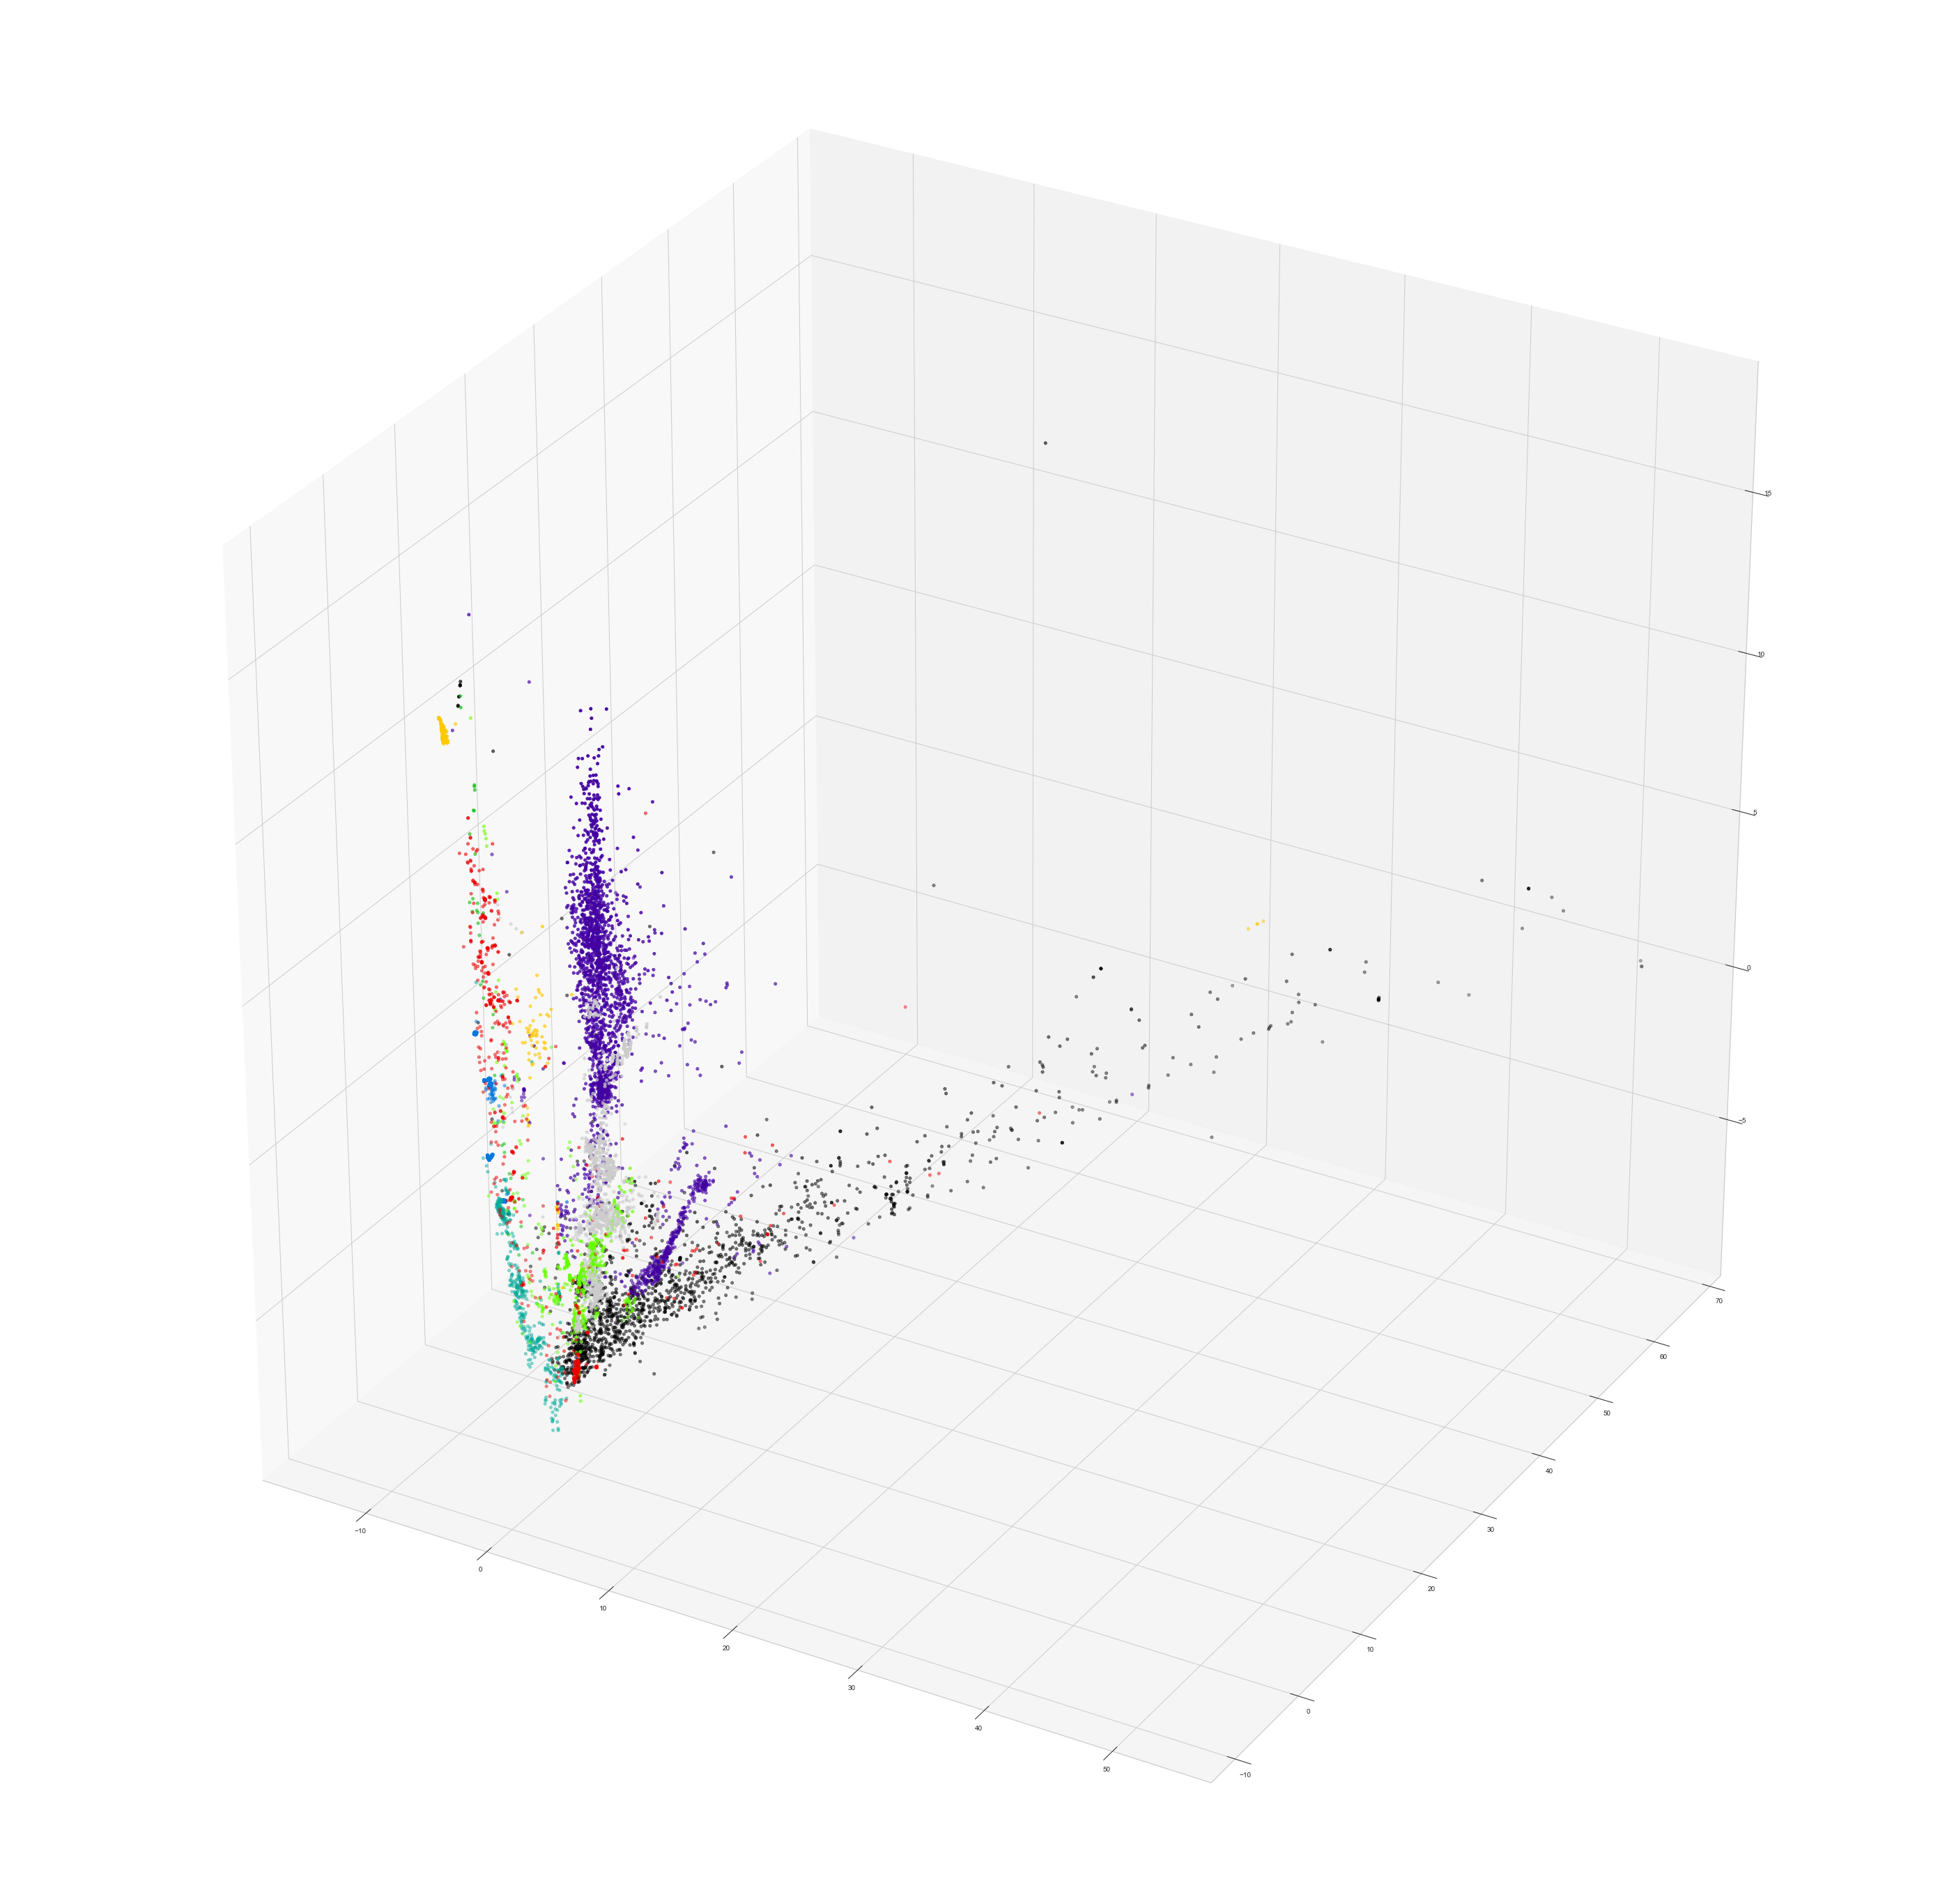

In [74]:
# pca
[selected_features_pca_train_cv5, selected_features_pca_test_cv5] = pca_plot(selected_features_rfc_train_cv5, selected_features_rfc_test_cv5, malware_classes_train.values.ravel().copy(), 'cv5_1')

In [ ]:
plt.figure(figsize=(15,5))

explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_cummulative = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1,X_pca.shape[1]+1), explained_variance_ratio, '-o', label='individualne komponente', c='b')
plt.plot(range(1,X_pca.shape[1]+1), explained_variance_ratio_cummulative, '-s', label='kumulativno', c='r')

print(sum(explained_variance_ratio_cummulative < 0.95))
print( explained_variance_ratio_cummulative)
plt.ylabel('Udio objašnjene varijance')
plt.xlabel('Glavna komponenta')
plt.xlim(0.75,X_pca.shape[1]+1.25)
plt.ylim(0,1.05)
plt.xticks(range(1,X_pca.shape[1]+1))
plt.legend(loc='center right')
plt.show()

Pogledajmo sada, nakon smanjivanja dimenzionalnosti, kako odabrane značajke koreliraju jedne s drugima.

In [ ]:
draw_heatmap_anNot(selected_features_pca_train_cv5, selected_features_pca_train_cv5.columns.values)

In [ ]:
draw_heatmap_anNot(selected_features_pca_test_cv5, selected_features_pca_test_cv5.columns.values)

<br>